In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import torch
import embedders
import pandas as pd

results = []

DIM = 2
N_SAMPLES = 100
N_POINTS = 1_000
N_CLASSES = 8
N_CLUSTERS = 32
MAX_DEPTH = 5
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.1
TASK = "classification"

SCORE = "f1-micro" if TASK == "classification" else "rmse"

# ABLATION_VAR = "use_special_dims"
# ABLATION_VALS = [False, True]

# ABLATION_VAR = "max_features"
# ABLATION_VALS = ["sqrt", "log2", "none"]

# ABLATION_VAR = "max_depth"
# ABLATION_VALS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ABLATION_VAR = "n_features"
ABLATION_VALS = ["d", "d_choose_2"]

USE_DT = True
USE_RF = True
# USE_RF = False

with torch.no_grad():
    my_tqdm = tqdm(total=N_SAMPLES)
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed
        pm = embedders.manifolds.ProductManifold(signature=[(-1, 2), (0, 2), (1, 2)])

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            num_clusters=N_CLUSTERS,
            cov_scale_means=1.0 / DIM,
            cov_scale_points=0.1 / DIM,
            task=TASK,
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Decision trees
        if USE_DT:
            base_dt_args = {"pm": pm, "max_depth": MAX_DEPTH, "task": TASK}
            dts = {
                val: embedders.tree_new.ProductSpaceDT(**base_dt_args | {ABLATION_VAR: val}) for val in ABLATION_VALS
            }
            for dt in dts.values():
                dt.fit(X_train, y_train)

        # Random forests
        if USE_RF:
            base_rf_args = {"pm": pm, "max_depth": MAX_DEPTH, "task": TASK, "n_estimators": 12, "random_state": seed}
            rfs = {
                val: embedders.tree_new.ProductSpaceRF(**base_rf_args | {ABLATION_VAR: val}) for val in ABLATION_VALS
            }
            for rf in rfs.values():
                rf.fit(X_train, y_train)

        # Get F1-scores
        y_test = y_test.detach().cpu().numpy()
        pred = lambda X, clf: clf.predict(X).detach().cpu().numpy()
        res = {"seed": seed}
        for val in ABLATION_VALS:
            res[f"dt_{val}_test"] = f1_score(y_test, pred(X_test, dts[val]), average="micro") if USE_DT else None
            res[f"rf_{val}_test"] = f1_score(y_test, pred(X_test, rfs[val]), average="micro") if USE_RF else None
            res[f"dt_{val}_train"] = f1_score(y_train, pred(X_train, dts[val]), average="micro") if USE_DT else None
            res[f"rf_{val}_train"] = f1_score(y_train, pred(X_train, rfs[val]), average="micro") if USE_RF else None
        results.append(res)

        my_tqdm.update(1)

results = pd.DataFrame(results)
results

  0%|          | 0/100 [00:00<?, ?it/s]

,seed,dt_d_test,rf_d_test,dt_d_train,rf_d_train,dt_d_choose_2_test,rf_d_choose_2_test,dt_d_choose_2_train,rf_d_choose_2_train
0,0,0.645,0.710,0.63750,0.77375,0.580,0.750,0.68000,0.80500
1,1,0.570,0.570,0.57625,0.67625,0.685,0.620,0.70500,0.69500
2,2,0.700,0.735,0.75875,0.83375,0.690,0.785,0.78125,0.84250
3,3,0.590,0.760,0.66125,0.81250,0.600,0.785,0.71375,0.86875
4,4,0.635,0.745,0.71125,0.86625,0.670,0.795,0.73000,0.90125
...,...,...,...,...,...,...,...,...,...
95,95,0.685,0.790,0.70750,0.85375,0.730,0.825,0.73125,0.86875
96,96,0.660,0.700,0.68875,0.81625,0.620,0.755,0.69750,0.84375
97,97,0.725,0.710,0.79625,0.82625,0.645,0.705,0.74375,0.78125
98,98,0.555,0.690,0.68750,0.79250,0.575,0.665,0.67125,0.82625


In [94]:
results.mean()

seed                   49.500000
dt_d_test               0.607000
rf_d_test               0.725100
dt_d_train              0.671600
rf_d_train              0.809675
dt_d_choose_2_test      0.620500
rf_d_choose_2_test      0.746500
dt_d_choose_2_train     0.692338
rf_d_choose_2_train     0.834888
dtype: float64

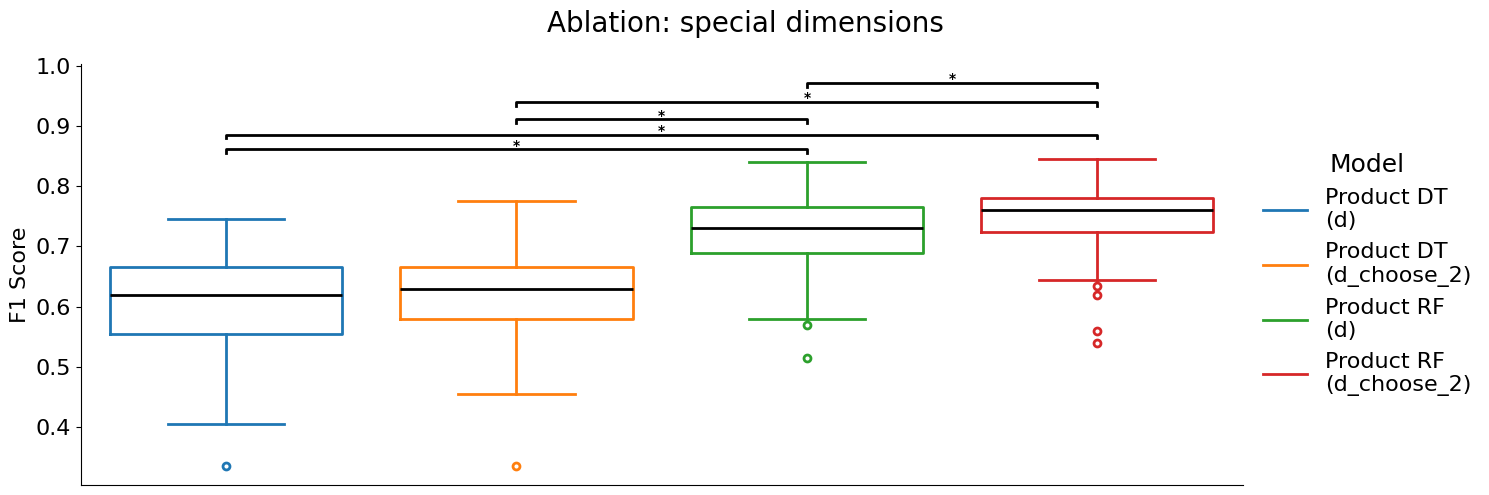

In [95]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

SIGNIFICANCE = "sig"
# SIGNIFICANCE = "ns"
CORRECTION = "bonferroni"
# CORRECTION = "none"

Y_LABEL = "F1 Score" if TASK == "classification" else "Root Mean Squared Error"


def test(x, y):
    # Check x and y are identical
    all_same = True
    for a, b in zip(x, y):
        if a != b:
            all_same = False
            break
    if all_same:
        return 1.0
    else:
        return wilcoxon(x, y).pvalue


# All the spec happens up here
# models = [f"dt_{val}" for val in ABLATION_VALS] + [f"rf_{val}" for val in ABLATION_VALS]
dts = [f"dt_{val}_test" for val in ABLATION_VALS] if USE_DT else []
rfs = [f"rf_{val}_test" for val in ABLATION_VALS] if USE_RF else []
models = dts + rfs
# model_names = ["Product DT", "Product DT\n(+ Special dims)", "Product RF", "Product RF\n(+ Special dims)"]
# model_names = ["$\\sqrt{D}$", "$\\log_2{D}$", "$D$"]
model_names = ABLATION_VALS
model_names_dt = [f"Product DT\n({val})" for val in ABLATION_VALS]
model_names_rf = [f"Product RF\n({val})" for val in ABLATION_VALS]
model_names = model_names_dt + model_names_rf
colors = [f"C{i}" for i in range(len(models))]

results["curvature"] = 0
CURVATURES = [0]

# Critical p-value depends on false discovery correction
CRITICAL_VAL = 0.05
if CORRECTION == "bonferroni":
    CRITICAL_VAL /= len(models) * (len(models) - 1) / 2

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models) + 1)

# for ax, models, model_names in zip(
#     axs, [models1 + models3, models2 + models3], [model_names1 + model_names3, model_names2 + model_names3]
# ):
bps = []
for i, (model, color) in enumerate(zip(models, colors)):
    # Initial boxplot
    bp = ax.boxplot(
        [results[results["curvature"] == K][model] for K in CURVATURES],
        positions=x_vals + i,
        widths=0.8,
        boxprops=dict(color=color, linewidth=2),
    )

    # Fix colors
    for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
        plt.setp(bp[element], color=color, linewidth=2)
    plt.setp(bp["medians"], color="black", linewidth=2)
    plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

    bps.append(bp)

# # Flip y-axis for RMSE
# if TASK == "regression":
#     ax.invert_yaxis()

# Add p-value annotations. All start at x_vals, and end at x_vals + i
heights = [0] * len(CURVATURES)  # How many annotations per curvature
# for i, j in [(0, 1), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3)]:
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        results_K = [results[results["curvature"] == K] for K in CURVATURES]
        p_vals = [test(res[models[i]], res[models[j]]) for res in results_K]
        ymin, ymax = ax.get_ylim()
        em = ymax - ymin

        for k, p_val in enumerate(p_vals):
            if (SIGNIFICANCE == "ns" and p_val > CRITICAL_VAL) or (SIGNIFICANCE == "sig" and p_val < CRITICAL_VAL):
                x1, x2 = x_vals[k] + i, x_vals[k] + j
                height = results[results["curvature"] == CURVATURES[k]][models].max().max() + 0.04 * em * (
                    heights[k] + 1
                )
                annotation = "*" if SIGNIFICANCE == "sig" else "ns"
                ax.text(
                    s=annotation,
                    x=(x1 + x2) / 2,
                    y=height,
                    ha="center",
                    va="center",
                    color="black",
                    fontdict={"weight": "bold"},
                )
                ax.plot(
                    [x1, x1, x2, x2],
                    [height - 0.02 * em, height - 0.01 * em, height - 0.01 * em, height - 0.02 * em],
                    lw=2,
                    color="black",
                )
                heights[k] += 1

# Fix y-lim and remove top/right spines; make background transparent
ax.patch.set_alpha(0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-ticks
ax.set_ylabel(Y_LABEL, fontsize=16)
ax.set_xticks(x_vals + 1.5, CURVATURES, fontsize=16)
# ax.legend([bp["boxes"][0] for bp in bps], model_names, fontsize=14, frameon=False, title="Model")
# Make legend to the right of the plot
ax.legend(
    [bp["boxes"][0] for bp in bps],
    model_names,
    fontsize=16,
    frameon=False,
    title="Model",
    title_fontsize=18,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax.tick_params(axis="y", labelsize=16)
# ax.set_yscale("log") if TASK == "regression" else None

# axs[0].set_title("Decision Trees", fontsize=18)
# axs[1].set_title("Random Forests", fontsize=18)
# axs[1].set_xlabel("Curvature", fontsize=16)

# plt.xlim(-1, len(CURVATURES) * (len(models) + 1))
plt.suptitle(f"Ablation: special dimensions", fontsize=20)

# Turn off xticks
plt.xticks([])

plt.tight_layout()

# Save as pdf
plt.savefig(f"../figures/ablation_{ABLATION_VAR}.pdf", bbox_inches="tight")
plt.show()